# OLED Optimization with FourierFields


In [31]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[ALU],)
                    

<Axes: xlabel='X', ylabel='Y'>

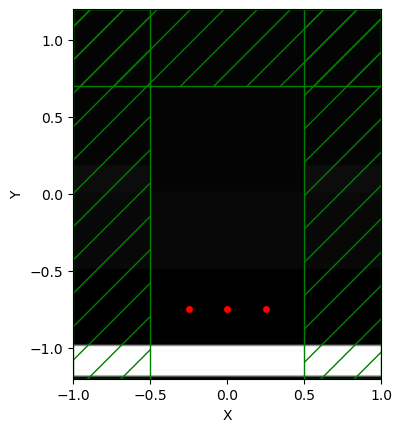

In [3]:
sim.plot2D()

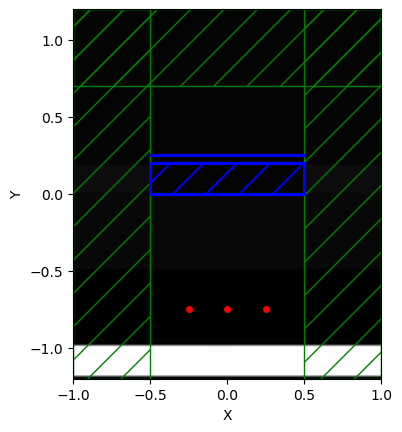

In [4]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)
opt.plot2D(True)

In [5]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [6]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [7]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    print("FoM: {}".format(np.real(f0)))
    print("Gradient: {}".format(np.real(dJ_du)))

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [8]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.3196781343445309
Gradient: [-8.55985830e-05 -1.59765836e-04 -5.65799938e-05  9.08204317e-05
  2.19355055e-04  2.83225723e-04  1.55536090e-04 -7.97777491e-06
 -1.59203785e-04 -2.35271981e-04 -3.00898560e-04 -8.28515907e-05
 -1.56227914e-04 -5.93298446e-05  8.46424372e-05  2.13812052e-04
  2.80116199e-04  1.52567078e-04 -1.60632604e-05 -1.75303759e-04
 -2.58661510e-04 -3.42025791e-04 -1.10041850e-04 -2.11310145e-04
 -9.17641973e-05  9.42582748e-05  2.67056540e-04  3.61663315e-04
  2.01320232e-04 -1.98031702e-05 -2.33263004e-04 -3.48580511e-04
 -4.68806743e-04 -1.41886088e-04 -2.79271170e-04 -1.42087430e-04
  8.59774470e-05  3.07813401e-04  4.40672013e-04  2.57420263e-04
 -1.15651114e-05 -2.78781527e-04 -4.28273770e-04 -5.84272196e-04
 -1.77672980e-04 -3.59760450e-04 -2.13137324e-04  5.44579390e-05
  3.29982931e-04  5.12725891e-04  3.21362011e-04  1.35552614e-05
 -3.03910769e-04 -4.89136068e-04 -6.78882792e-04 -2.15700025e-04
 -4.49967369e-04 -3.04862611e-04

Calculating gradient...
FoM: 0.3197766904088262
Gradient: [-8.56706996e-05 -1.59913678e-04 -5.66747379e-05  9.08244125e-05
  2.19469603e-04  2.83439165e-04  1.55720210e-04 -7.86997704e-06
 -1.59197674e-04 -2.35354637e-04 -3.01105000e-04 -8.29158875e-05
 -1.56361985e-04 -5.94215903e-05  8.46372668e-05  2.13907768e-04
  2.80302971e-04  1.52727441e-04 -1.59751546e-05 -1.75311269e-04
 -2.58751303e-04 -3.42233360e-04 -1.10119894e-04 -2.11475703e-04
 -9.18852768e-05  9.42377973e-05  2.67157851e-04  3.61875394e-04
  2.01501946e-04 -1.97106891e-05 -2.33287883e-04 -3.48704828e-04
 -4.69076374e-04 -1.41976434e-04 -2.79466659e-04 -1.42241071e-04
  8.59331054e-05  3.07907869e-04  4.40894478e-04  2.57611579e-04
 -1.14769688e-05 -2.78828683e-04 -4.28433682e-04 -5.84599718e-04
 -1.77772977e-04 -3.59981670e-04 -2.13324426e-04  5.43827407e-05
  3.30058906e-04  5.12944764e-04  3.21553047e-04  1.36331179e-05
 -3.03981958e-04 -4.89329701e-04 -6.79260995e-04 -2.15805916e-04
 -4.50207428e-04 -3.05080975e-04

Calculating gradient...
FoM: 0.32075156488079765
Gradient: [-8.63844973e-05 -1.61377754e-04 -5.76155049e-05  9.08578968e-05
  2.20594673e-04  2.85539621e-04  1.57530749e-04 -6.81400070e-06
 -1.59145928e-04 -2.36178467e-04 -3.03151512e-04 -8.35520101e-05
 -1.57688957e-04 -6.03313930e-05  8.45819608e-05  2.14848697e-04
  2.82142296e-04  1.54305326e-04 -1.51120156e-05 -1.75392946e-04
 -2.59645298e-04 -3.44292195e-04 -1.10891781e-04 -2.13113608e-04
 -9.30846992e-05  9.40315591e-05  2.68154643e-04  3.63965714e-04
  2.03291509e-04 -1.88040436e-05 -2.33541464e-04 -3.49940916e-04
 -4.71751268e-04 -1.42869729e-04 -2.81399953e-04 -1.43761726e-04
  8.54918113e-05  3.08838291e-04  4.43089568e-04  2.59498189e-04
 -1.06113690e-05 -2.79301254e-04 -4.30021402e-04 -5.87848989e-04
 -1.78761487e-04 -3.62168815e-04 -2.15175119e-04  5.36374256e-05
  3.30808142e-04  5.15107269e-04  3.23440201e-04  1.44003032e-05
 -3.04689471e-04 -4.91249438e-04 -6.83012624e-04 -2.16852531e-04
 -4.52580355e-04 -3.07240113e-0

Calculating gradient...
FoM: 0.3332696478292954
Gradient: [-9.56526375e-05 -1.80515370e-04 -7.03249348e-05  9.03618561e-05
  2.33895756e-04  3.11091367e-04  1.79460506e-04  5.51008900e-06
 -1.59516009e-04 -2.47521043e-04 -3.30077466e-04 -9.17629754e-05
 -1.74910737e-04 -7.24344017e-05  8.32009635e-05  2.26080199e-04
  3.04694837e-04  1.73549690e-04 -5.01485482e-06 -1.77307775e-04
 -2.71827188e-04 -3.71509514e-04 -1.20807872e-04 -2.34245161e-04
 -1.08835507e-04  9.07647309e-05  2.80159268e-04  3.89827579e-04
  2.25329993e-04 -8.09826331e-06 -2.37655486e-04 -3.66579098e-04
 -5.07169358e-04 -1.54295146e-04 -3.06207500e-04 -1.63509957e-04
  7.93377095e-05  3.20156270e-04  4.70557247e-04  2.83054747e-04
 -1.79579003e-07 -2.86038762e-04 -4.51112537e-04 -6.30888706e-04
 -1.91355458e-04 -3.90104078e-04 -2.39006594e-04  4.37489682e-05
  3.40023356e-04  5.42532149e-04  3.47431549e-04  2.40006688e-05
 -3.14083847e-04 -5.16409861e-04 -7.32671096e-04 -2.30140699e-04
 -4.82774599e-04 -3.34885197e-04

Calculating gradient...
FoM: 0.4287965802235561
Gradient: [-1.70839767e-04 -3.42825086e-04 -1.99328112e-04  4.27152349e-05
  2.88752904e-04  4.60741228e-04  3.13220259e-04  7.09335210e-05
 -1.87544212e-04 -3.58880509e-04 -5.78430024e-04 -1.55024859e-04
 -3.13271599e-04 -1.86040725e-04  4.01089007e-05  2.76764174e-04
  4.44875102e-04  2.99016866e-04  5.51577354e-05 -2.06472455e-04
 -3.81225265e-04 -6.16168769e-04 -1.93837710e-04 -3.96127530e-04
 -2.46725146e-04  3.40332286e-05  3.37243391e-04  5.59159710e-04
  3.78940093e-04  6.50050256e-05 -2.75630831e-04 -5.05294393e-04
 -8.19188849e-04 -2.34525740e-04 -4.87176507e-04 -3.25241817e-04
  4.37540375e-06  3.75500823e-04  6.60217953e-04  4.60091784e-04
  8.47316150e-05 -3.30691252e-04 -6.14976887e-04 -1.00353328e-03
 -2.75375329e-04 -5.83976048e-04 -4.22958780e-04 -5.39608554e-05
  3.84171872e-04  7.41841857e-04  5.42708664e-04  1.20489316e-04
 -3.61522682e-04 -6.99050557e-04 -1.15577124e-03 -3.13829845e-04
 -6.81733853e-04 -5.37817328e-04

Calculating gradient...
FoM: 0.5443120786117914
Gradient: [-2.10443773e-04 -4.28649173e-04 -2.63423090e-04  4.64426616e-05
  4.10600490e-04  7.20245884e-04  5.58542109e-04  2.32528048e-04
 -1.35980222e-04 -4.21266849e-04 -8.54552921e-04 -1.81601567e-04
 -3.76362497e-04 -2.45735809e-04  2.85940170e-05  3.71183114e-04
  6.78908042e-04  5.40516390e-04  2.34630387e-04 -1.16732992e-04
 -3.89926500e-04 -7.97498414e-04 -2.17321094e-04 -4.59874806e-04
 -3.25353939e-04 -5.61071559e-06  4.15219690e-04  8.11517644e-04
  6.64892561e-04  2.94758229e-04 -1.41520062e-04 -4.83971818e-04
 -9.91435861e-04 -2.49717973e-04 -5.42622349e-04 -4.22407525e-04
 -7.57496362e-05  4.09111538e-04  8.91673686e-04  7.60249404e-04
  3.45013561e-04 -1.63036110e-04 -5.67848610e-04 -1.16529201e-03
 -2.75139979e-04 -6.17237930e-04 -5.31762965e-04 -1.78981961e-04
  3.52280396e-04  9.17116333e-04  8.26842882e-04  3.89502020e-04
 -1.74229216e-04 -6.33439117e-04 -1.30943969e-03 -2.89615466e-04
 -6.74948967e-04 -6.45047214e-04

Calculating gradient...
FoM: 0.5226811889377164
Gradient: [-1.90993940e-04 -3.38925118e-04 -7.86889020e-05  2.24333925e-04
  4.47333083e-04  4.46629997e-04  3.73993381e-05 -4.08048849e-04
 -7.45825447e-04 -8.99410950e-04 -1.23837973e-03 -1.78390129e-04
 -3.26905790e-04 -1.04557313e-04  1.83030894e-04  4.28411413e-04
  4.96108205e-04  1.50606615e-04 -2.55779707e-04 -5.83486490e-04
 -7.49711889e-04 -1.06670318e-03 -2.32275712e-04 -4.41489053e-04
 -1.89650632e-04  1.66255211e-04  5.05379088e-04  6.66002149e-04
  2.96536821e-04 -1.83244688e-04 -5.96538866e-04 -8.24545035e-04
 -1.21116105e-03 -2.93589149e-04 -5.80422008e-04 -3.17593283e-04
  9.54935230e-05  5.29584241e-04  8.09090687e-04  4.60362635e-04
 -6.30100901e-05 -5.49552975e-04 -8.40017729e-04 -1.28200636e-03
 -3.58475071e-04 -7.36730580e-04 -4.85958439e-04 -3.18187256e-05
  4.90625742e-04  9.04398998e-04  6.21298223e-04  8.80230051e-05
 -4.53653767e-04 -8.02830470e-04 -1.28616312e-03 -4.20853670e-04
 -8.97444760e-04 -6.84513410e-04

Calculating gradient...
FoM: 0.5414500642727874
Gradient: [-2.04919278e-04 -3.76000072e-04 -1.19177224e-04  2.21940224e-04
  5.23665742e-04  6.45979973e-04  2.84374568e-04 -1.62936433e-04
 -5.55383514e-04 -7.85737106e-04 -1.20878194e-03 -1.88092561e-04
 -3.55842920e-04 -1.42416190e-04  1.71562738e-04  4.79905072e-04
  6.50922685e-04  3.50448496e-04 -5.53379658e-05 -4.27117667e-04
 -6.55734041e-04 -1.03927240e-03 -2.39733249e-04 -4.69291583e-04
 -2.35722613e-04  1.41250598e-04  5.43166129e-04  8.12904722e-04
  4.97426498e-04  2.11307679e-05 -4.37560607e-04 -7.31429555e-04
 -1.19107335e-03 -2.95125312e-04 -5.99601367e-04 -3.67518029e-04
  5.47213751e-05  5.42416135e-04  9.24627938e-04  6.35187789e-04
  1.18790752e-04 -4.09894118e-04 -7.63808156e-04 -1.28243735e-03
 -3.49647187e-04 -7.37533307e-04 -5.31596844e-04 -8.50834412e-05
  4.74483377e-04  9.74662324e-04  7.51451260e-04  2.27884185e-04
 -3.49814408e-04 -7.55753101e-04 -1.31701352e-03 -3.97285576e-04
 -8.69701736e-04 -7.15382660e-04

Calculating gradient...
FoM: 0.549733282606035
Gradient: [-2.16110030e-04 -4.20408958e-04 -2.03590810e-04  1.39821926e-04
  5.03178447e-04  7.62697843e-04  5.13008402e-04  1.22384486e-04
 -2.78994601e-04 -5.64119503e-04 -1.02007139e-03 -1.91142716e-04
 -3.80565803e-04 -2.06322831e-04  1.00671969e-04  4.50124600e-04
  7.25156013e-04  5.17106703e-04  1.58654158e-04 -2.19693085e-04
 -4.92278205e-04 -9.09301108e-04 -2.34606977e-04 -4.79754252e-04
 -2.96192705e-04  6.39271966e-05  4.99404197e-04  8.69251869e-04
  6.51542126e-04  2.25867892e-04 -2.39193752e-04 -5.79780065e-04
 -1.08628816e-03 -2.77002713e-04 -5.84418340e-04 -4.12618849e-04
 -1.97419469e-05  4.87802483e-04  9.54085065e-04  7.57826568e-04
  2.89690059e-04 -2.45697129e-04 -6.46161915e-04 -1.22738297e-03
 -3.13790436e-04 -6.85130058e-04 -5.48273856e-04 -1.45430823e-04
  4.15651635e-04  9.75928723e-04  8.32794995e-04  3.50024251e-04
 -2.36110676e-04 -6.86940148e-04 -1.32786440e-03 -3.40049489e-04
 -7.70764545e-04 -6.91915092e-04 

Calculating gradient...
FoM: 0.5552484612434853
Gradient: [-2.18116924e-04 -4.17609997e-04 -1.78913688e-04  1.92896199e-04
  5.80451903e-04  8.56996580e-04  5.85173835e-04  1.68643508e-04
 -2.58163902e-04 -5.58568593e-04 -1.02127744e-03 -1.95377292e-04
 -3.84974361e-04 -1.95035827e-04  1.33500066e-04  5.02483029e-04
  7.91155621e-04  5.68009637e-04  1.90960182e-04 -2.05378623e-04
 -4.86961836e-04 -9.01917676e-04 -2.41895310e-04 -4.91651047e-04
 -2.94248534e-04  8.50543541e-05  5.38557667e-04  9.20727807e-04
  6.90661835e-04  2.49113367e-04 -2.30161775e-04 -5.75054789e-04
 -1.06978869e-03 -2.87403688e-04 -6.04341769e-04 -4.21989325e-04
 -1.49888718e-05  5.04872152e-04  9.79065767e-04  7.74869273e-04
  2.96238492e-04 -2.45946300e-04 -6.43150652e-04 -1.19943958e-03
 -3.27128151e-04 -7.12728862e-04 -5.68657286e-04 -1.56790947e-04
  4.09466621e-04  9.70897708e-04  8.23965381e-04  3.36775784e-04
 -2.47309192e-04 -6.86139237e-04 -1.28737193e-03 -3.56183937e-04
 -8.05513884e-04 -7.22073561e-04

Calculating gradient...
FoM: 0.5561585792192365
Gradient: [-2.11194679e-04 -3.99403701e-04 -1.56891834e-04  2.06998961e-04
  5.71715987e-04  8.05256207e-04  5.03224662e-04  7.07352987e-05
 -3.53780324e-04 -6.40619048e-04 -1.10850197e-03 -1.91913021e-04
 -3.74244825e-04 -1.78754395e-04  1.46821586e-04  5.01028030e-04
  7.59273932e-04  5.12573672e-04  1.22927186e-04 -2.72267544e-04
 -5.44311145e-04 -9.62299149e-04 -2.41438861e-04 -4.86377878e-04
 -2.79811071e-04  1.00476475e-04  5.43041836e-04  8.99693645e-04
  6.46756544e-04  1.92379326e-04 -2.87012883e-04 -6.23851433e-04
 -1.12003101e-03 -2.92369382e-04 -6.09842000e-04 -4.14081342e-04
 -4.01115033e-07  5.15132596e-04  9.73654404e-04  7.50839400e-04
  2.60885165e-04 -2.82955266e-04 -6.74915263e-04 -1.23023709e-03
 -3.40186993e-04 -7.35181710e-04 -5.73517790e-04 -1.48009108e-04
  4.22856204e-04  9.80774899e-04  8.22435435e-04  3.27261901e-04
 -2.59479720e-04 -6.96239334e-04 -1.29354867e-03 -3.79671896e-04
 -8.50435864e-04 -7.45773589e-04

Calculating gradient...
FoM: 0.5561587434717605
Gradient: [-2.40145204e-04 -4.60228191e-04 -2.01965163e-04  1.92682958e-04
  6.04020783e-04  9.06726796e-04  6.41301387e-04  2.25051609e-04
 -2.07786486e-04 -5.15624510e-04 -9.69036671e-04 -2.10520321e-04
 -4.14738192e-04 -2.12895299e-04  1.28760745e-04  5.10629943e-04
  8.12264951e-04  5.92435659e-04  2.15533155e-04 -1.83099040e-04
 -4.66932981e-04 -8.74261417e-04 -2.55258091e-04 -5.17930987e-04
 -3.10684833e-04  7.73270527e-05  5.36914112e-04  9.23361865e-04
  6.94045147e-04  2.52476910e-04 -2.26093957e-04 -5.68909197e-04
 -1.05426730e-03 -2.96901758e-04 -6.22391240e-04 -4.32262333e-04
 -2.16545751e-05  4.95310343e-04  9.62042211e-04  7.53864085e-04
  2.74262124e-04 -2.63958370e-04 -6.53962885e-04 -1.19876920e-03
 -3.31300789e-04 -7.19040229e-04 -5.68574626e-04 -1.57209455e-04
  3.98321872e-04  9.39557761e-04  7.81725474e-04  2.91358972e-04
 -2.86448407e-04 -7.13536020e-04 -1.30144098e-03 -3.54600248e-04
 -7.98649910e-04 -7.08850305e-04

Calculating gradient...
FoM: 0.5561587434717605
Gradient: [-2.40145204e-04 -4.60228191e-04 -2.01965163e-04  1.92682958e-04
  6.04020783e-04  9.06726796e-04  6.41301387e-04  2.25051609e-04
 -2.07786486e-04 -5.15624510e-04 -9.69036671e-04 -2.10520321e-04
 -4.14738192e-04 -2.12895299e-04  1.28760745e-04  5.10629943e-04
  8.12264951e-04  5.92435659e-04  2.15533155e-04 -1.83099040e-04
 -4.66932981e-04 -8.74261417e-04 -2.55258091e-04 -5.17930987e-04
 -3.10684833e-04  7.73270527e-05  5.36914112e-04  9.23361865e-04
  6.94045147e-04  2.52476910e-04 -2.26093957e-04 -5.68909197e-04
 -1.05426730e-03 -2.96901758e-04 -6.22391240e-04 -4.32262333e-04
 -2.16545751e-05  4.95310343e-04  9.62042211e-04  7.53864085e-04
  2.74262124e-04 -2.63958370e-04 -6.53962885e-04 -1.19876920e-03
 -3.31300789e-04 -7.19040229e-04 -5.68574626e-04 -1.57209455e-04
  3.98321872e-04  9.39557761e-04  7.81725474e-04  2.91358972e-04
 -2.86448407e-04 -7.13536020e-04 -1.30144098e-03 -3.54600248e-04
 -7.98649910e-04 -7.08850305e-04

Calculating gradient...
FoM: 0.5561587755895785
Gradient: [-2.40142704e-04 -4.60222957e-04 -2.01961273e-04  1.92684441e-04
  6.04018742e-04  9.06719641e-04  6.41291426e-04  2.25040296e-04
 -2.07797414e-04 -5.15634146e-04 -9.69048021e-04 -2.10518800e-04
 -4.14734914e-04 -2.12892588e-04  1.28762240e-04  5.10629455e-04
  8.12261457e-04  5.92430259e-04  2.15526779e-04 -1.83105332e-04
 -4.66938643e-04 -8.74268300e-04 -2.55257051e-04 -5.17928655e-04
 -3.10682628e-04  7.73287113e-05  5.36914687e-04  9.23360644e-04
  6.94042444e-04  2.52473327e-04 -2.26097766e-04 -5.68912859e-04
 -1.05427219e-03 -2.96901557e-04 -6.22390652e-04 -4.32261392e-04
 -2.16533349e-05  4.95311743e-04  9.62043597e-04  7.53864864e-04
  2.74262329e-04 -2.63958716e-04 -6.53963707e-04 -1.19877121e-03
 -3.31301731e-04 -7.19042099e-04 -5.68575722e-04 -1.57209404e-04
  3.98323372e-04  9.39561213e-04  7.81729562e-04  2.91363028e-04
 -2.86445092e-04 -7.13533766e-04 -1.30143983e-03 -3.54602507e-04
 -7.98654686e-04 -7.08854032e-04

Calculating gradient...
FoM: 0.5561587755895785
Gradient: [-2.40142704e-04 -4.60222957e-04 -2.01961273e-04  1.92684441e-04
  6.04018742e-04  9.06719641e-04  6.41291426e-04  2.25040296e-04
 -2.07797414e-04 -5.15634146e-04 -9.69048021e-04 -2.10518800e-04
 -4.14734914e-04 -2.12892588e-04  1.28762240e-04  5.10629455e-04
  8.12261457e-04  5.92430259e-04  2.15526779e-04 -1.83105332e-04
 -4.66938643e-04 -8.74268300e-04 -2.55257051e-04 -5.17928655e-04
 -3.10682628e-04  7.73287113e-05  5.36914687e-04  9.23360644e-04
  6.94042444e-04  2.52473327e-04 -2.26097766e-04 -5.68912859e-04
 -1.05427219e-03 -2.96901557e-04 -6.22390652e-04 -4.32261392e-04
 -2.16533349e-05  4.95311743e-04  9.62043597e-04  7.53864864e-04
  2.74262329e-04 -2.63958716e-04 -6.53963707e-04 -1.19877121e-03
 -3.31301731e-04 -7.19042099e-04 -5.68575722e-04 -1.57209404e-04
  3.98323372e-04  9.39561213e-04  7.81729562e-04  2.91363028e-04
 -2.86445092e-04 -7.13533766e-04 -1.30143983e-03 -3.54602507e-04
 -7.98654686e-04 -7.08854032e-04

Calculating gradient...
FoM: 0.5561588076994771
Gradient: [-2.40140204e-04 -4.60217724e-04 -2.01957383e-04  1.92685925e-04
  6.04016700e-04  9.06712486e-04  6.41281468e-04  2.25028984e-04
 -2.07808341e-04 -5.15643780e-04 -9.69059370e-04 -2.10517279e-04
 -4.14731637e-04 -2.12889876e-04  1.28763734e-04  5.10628968e-04
  8.12257962e-04  5.92424859e-04  2.15520404e-04 -1.83111623e-04
 -4.66944305e-04 -8.74275183e-04 -2.55256012e-04 -5.17926322e-04
 -3.10680424e-04  7.73303698e-05  5.36915262e-04  9.23359423e-04
  6.94039741e-04  2.52469743e-04 -2.26101575e-04 -5.68916521e-04
 -1.05427707e-03 -2.96901357e-04 -6.22390064e-04 -4.32260451e-04
 -2.16520947e-05  4.95313143e-04  9.62044984e-04  7.53865642e-04
  2.74262533e-04 -2.63959061e-04 -6.53964530e-04 -1.19877323e-03
 -3.31302672e-04 -7.19043968e-04 -5.68576818e-04 -1.57209353e-04
  3.98324872e-04  9.39564665e-04  7.81733650e-04  2.91367084e-04
 -2.86441778e-04 -7.13531513e-04 -1.30143867e-03 -3.54604766e-04
 -7.98659461e-04 -7.08857759e-04

Calculating gradient...
FoM: 0.5561588076994771
Gradient: [-2.40140204e-04 -4.60217724e-04 -2.01957383e-04  1.92685925e-04
  6.04016700e-04  9.06712486e-04  6.41281468e-04  2.25028984e-04
 -2.07808341e-04 -5.15643780e-04 -9.69059370e-04 -2.10517279e-04
 -4.14731637e-04 -2.12889876e-04  1.28763734e-04  5.10628968e-04
  8.12257962e-04  5.92424859e-04  2.15520404e-04 -1.83111623e-04
 -4.66944305e-04 -8.74275183e-04 -2.55256012e-04 -5.17926322e-04
 -3.10680424e-04  7.73303698e-05  5.36915262e-04  9.23359423e-04
  6.94039741e-04  2.52469743e-04 -2.26101575e-04 -5.68916521e-04
 -1.05427707e-03 -2.96901357e-04 -6.22390064e-04 -4.32260451e-04
 -2.16520947e-05  4.95313143e-04  9.62044984e-04  7.53865642e-04
  2.74262533e-04 -2.63959061e-04 -6.53964530e-04 -1.19877323e-03
 -3.31302672e-04 -7.19043968e-04 -5.68576818e-04 -1.57209353e-04
  3.98324872e-04  9.39564665e-04  7.81733650e-04  2.91367084e-04
 -2.86441778e-04 -7.13531513e-04 -1.30143867e-03 -3.54604766e-04
 -7.98659461e-04 -7.08857759e-04

Calculating gradient...
FoM: 0.556158839801459
Gradient: [-2.40137705e-04 -4.60212492e-04 -2.01953494e-04  1.92687408e-04
  6.04014659e-04  9.06705332e-04  6.41271510e-04  2.25017674e-04
 -2.07819265e-04 -5.15653414e-04 -9.69070717e-04 -2.10515759e-04
 -4.14728361e-04 -2.12887165e-04  1.28765228e-04  5.10628481e-04
  8.12254469e-04  5.92419460e-04  2.15514031e-04 -1.83117913e-04
 -4.66949965e-04 -8.74282065e-04 -2.55254973e-04 -5.17923990e-04
 -3.10678220e-04  7.73320282e-05  5.36915837e-04  9.23358201e-04
  6.94037039e-04  2.52466161e-04 -2.26105383e-04 -5.68920182e-04
 -1.05428196e-03 -2.96901156e-04 -6.22389476e-04 -4.32259511e-04
 -2.16508546e-05  4.95314543e-04  9.62046371e-04  7.53866421e-04
  2.74262737e-04 -2.63959407e-04 -6.53965353e-04 -1.19877524e-03
 -3.31303614e-04 -7.19045837e-04 -5.68577914e-04 -1.57209303e-04
  3.98326371e-04  9.39568117e-04  7.81737737e-04  2.91371139e-04
 -2.86438464e-04 -7.13529260e-04 -1.30143752e-03 -3.54607025e-04
 -7.98664236e-04 -7.08861484e-04 

Calculating gradient...
FoM: 0.556158839801459
Gradient: [-2.40137705e-04 -4.60212492e-04 -2.01953494e-04  1.92687408e-04
  6.04014659e-04  9.06705332e-04  6.41271510e-04  2.25017674e-04
 -2.07819265e-04 -5.15653414e-04 -9.69070717e-04 -2.10515759e-04
 -4.14728361e-04 -2.12887165e-04  1.28765228e-04  5.10628481e-04
  8.12254469e-04  5.92419460e-04  2.15514031e-04 -1.83117913e-04
 -4.66949965e-04 -8.74282065e-04 -2.55254973e-04 -5.17923990e-04
 -3.10678220e-04  7.73320282e-05  5.36915837e-04  9.23358201e-04
  6.94037039e-04  2.52466161e-04 -2.26105383e-04 -5.68920182e-04
 -1.05428196e-03 -2.96901156e-04 -6.22389476e-04 -4.32259511e-04
 -2.16508546e-05  4.95314543e-04  9.62046371e-04  7.53866421e-04
  2.74262737e-04 -2.63959407e-04 -6.53965353e-04 -1.19877524e-03
 -3.31303614e-04 -7.19045837e-04 -5.68577914e-04 -1.57209303e-04
  3.98326371e-04  9.39568117e-04  7.81737737e-04  2.91371139e-04
 -2.86438464e-04 -7.13529260e-04 -1.30143752e-03 -3.54607025e-04
 -7.98664236e-04 -7.08861484e-04 

Calculating gradient...
FoM: 0.5561588718955263
Gradient: [-2.40135206e-04 -4.60207261e-04 -2.01949606e-04  1.92688891e-04
  6.04012619e-04  9.06698180e-04  6.41261554e-04  2.25006365e-04
 -2.07830188e-04 -5.15663046e-04 -9.69082063e-04 -2.10514238e-04
 -4.14725085e-04 -2.12884455e-04  1.28766722e-04  5.10627994e-04
  8.12250976e-04  5.92414062e-04  2.15507658e-04 -1.83124203e-04
 -4.66955625e-04 -8.74288945e-04 -2.55253935e-04 -5.17921659e-04
 -3.10676017e-04  7.73336863e-05  5.36916413e-04  9.23356981e-04
  6.94034337e-04  2.52462579e-04 -2.26109190e-04 -5.68923842e-04
 -1.05428684e-03 -2.96900956e-04 -6.22388889e-04 -4.32258570e-04
 -2.16496147e-05  4.95315943e-04  9.62047757e-04  7.53867199e-04
  2.74262941e-04 -2.63959752e-04 -6.53966175e-04 -1.19877725e-03
 -3.31304555e-04 -7.19047706e-04 -5.68579009e-04 -1.57209252e-04
  3.98327871e-04  9.39571568e-04  7.81741824e-04  2.91375194e-04
 -2.86435151e-04 -7.13527007e-04 -1.30143636e-03 -3.54609283e-04
 -7.98669010e-04 -7.08865210e-04

Calculating gradient...
FoM: 0.5561588718955263
Gradient: [-2.40135206e-04 -4.60207261e-04 -2.01949606e-04  1.92688891e-04
  6.04012619e-04  9.06698180e-04  6.41261554e-04  2.25006365e-04
 -2.07830188e-04 -5.15663046e-04 -9.69082063e-04 -2.10514238e-04
 -4.14725085e-04 -2.12884455e-04  1.28766722e-04  5.10627994e-04
  8.12250976e-04  5.92414062e-04  2.15507658e-04 -1.83124203e-04
 -4.66955625e-04 -8.74288945e-04 -2.55253935e-04 -5.17921659e-04
 -3.10676017e-04  7.73336863e-05  5.36916413e-04  9.23356981e-04
  6.94034337e-04  2.52462579e-04 -2.26109190e-04 -5.68923842e-04
 -1.05428684e-03 -2.96900956e-04 -6.22388889e-04 -4.32258570e-04
 -2.16496147e-05  4.95315943e-04  9.62047757e-04  7.53867199e-04
  2.74262941e-04 -2.63959752e-04 -6.53966175e-04 -1.19877725e-03
 -3.31304555e-04 -7.19047706e-04 -5.68579009e-04 -1.57209252e-04
  3.98327871e-04  9.39571568e-04  7.81741824e-04  2.91375194e-04
 -2.86435151e-04 -7.13527007e-04 -1.30143636e-03 -3.54609283e-04
 -7.98669010e-04 -7.08865210e-04

Calculating gradient...
FoM: 0.5561589039816812
Gradient: [-2.40132708e-04 -4.60202030e-04 -2.01945718e-04  1.92690374e-04
  6.04010578e-04  9.06691028e-04  6.41251599e-04  2.24995058e-04
 -2.07841110e-04 -5.15672677e-04 -9.69093407e-04 -2.10512719e-04
 -4.14721809e-04 -2.12881745e-04  1.28768215e-04  5.10627508e-04
  8.12247483e-04  5.92408665e-04  2.15501286e-04 -1.83130491e-04
 -4.66961284e-04 -8.74295825e-04 -2.55252896e-04 -5.17919327e-04
 -3.10673814e-04  7.73353442e-05  5.36916988e-04  9.23355760e-04
  6.94031636e-04  2.52458997e-04 -2.26112997e-04 -5.68927502e-04
 -1.05429172e-03 -2.96900755e-04 -6.22388301e-04 -4.32257629e-04
 -2.16483749e-05  4.95317342e-04  9.62049143e-04  7.53867977e-04
  2.74263145e-04 -2.63960098e-04 -6.53966997e-04 -1.19877926e-03
 -3.31305496e-04 -7.19049575e-04 -5.68580105e-04 -1.57209201e-04
  3.98329370e-04  9.39575019e-04  7.81745910e-04  2.91379247e-04
 -2.86431838e-04 -7.13524755e-04 -1.30143521e-03 -3.54611541e-04
 -7.98673783e-04 -7.08868934e-04

Calculating gradient...
FoM: 0.5561589039816812
Gradient: [-2.40132708e-04 -4.60202030e-04 -2.01945718e-04  1.92690374e-04
  6.04010578e-04  9.06691028e-04  6.41251599e-04  2.24995058e-04
 -2.07841110e-04 -5.15672677e-04 -9.69093407e-04 -2.10512719e-04
 -4.14721809e-04 -2.12881745e-04  1.28768215e-04  5.10627508e-04
  8.12247483e-04  5.92408665e-04  2.15501286e-04 -1.83130491e-04
 -4.66961284e-04 -8.74295825e-04 -2.55252896e-04 -5.17919327e-04
 -3.10673814e-04  7.73353442e-05  5.36916988e-04  9.23355760e-04
  6.94031636e-04  2.52458997e-04 -2.26112997e-04 -5.68927502e-04
 -1.05429172e-03 -2.96900755e-04 -6.22388301e-04 -4.32257629e-04
 -2.16483749e-05  4.95317342e-04  9.62049143e-04  7.53867977e-04
  2.74263145e-04 -2.63960098e-04 -6.53966997e-04 -1.19877926e-03
 -3.31305496e-04 -7.19049575e-04 -5.68580105e-04 -1.57209201e-04
  3.98329370e-04  9.39575019e-04  7.81745910e-04  2.91379247e-04
 -2.86431838e-04 -7.13524755e-04 -1.30143521e-03 -3.54611541e-04
 -7.98673783e-04 -7.08868934e-04

Calculating gradient...
FoM: 0.5561589360599263
Gradient: [-2.40130210e-04 -4.60196800e-04 -2.01941831e-04  1.92691856e-04
  6.04008538e-04  9.06683878e-04  6.41241646e-04  2.24983752e-04
 -2.07852030e-04 -5.15682306e-04 -9.69104749e-04 -2.10511199e-04
 -4.14718534e-04 -2.12879035e-04  1.28769708e-04  5.10627021e-04
  8.12243991e-04  5.92403269e-04  2.15494915e-04 -1.83136779e-04
 -4.66966942e-04 -8.74302704e-04 -2.55251858e-04 -5.17916996e-04
 -3.10671611e-04  7.73370019e-05  5.36917563e-04  9.23354540e-04
  6.94028935e-04  2.52455416e-04 -2.26116803e-04 -5.68931162e-04
 -1.05429660e-03 -2.96900555e-04 -6.22387713e-04 -4.32256689e-04
 -2.16471353e-05  4.95318742e-04  9.62050529e-04  7.53868756e-04
  2.74263349e-04 -2.63960443e-04 -6.53967820e-04 -1.19878126e-03
 -3.31306437e-04 -7.19051443e-04 -5.68581200e-04 -1.57209150e-04
  3.98330869e-04  9.39578469e-04  7.81749995e-04  2.91383301e-04
 -2.86428526e-04 -7.13522503e-04 -1.30143405e-03 -3.54613799e-04
 -7.98678555e-04 -7.08872658e-04

Calculating gradient...
FoM: 0.5561589360599263
Gradient: [-2.40130210e-04 -4.60196800e-04 -2.01941831e-04  1.92691856e-04
  6.04008538e-04  9.06683878e-04  6.41241646e-04  2.24983752e-04
 -2.07852030e-04 -5.15682306e-04 -9.69104749e-04 -2.10511199e-04
 -4.14718534e-04 -2.12879035e-04  1.28769708e-04  5.10627021e-04
  8.12243991e-04  5.92403269e-04  2.15494915e-04 -1.83136779e-04
 -4.66966942e-04 -8.74302704e-04 -2.55251858e-04 -5.17916996e-04
 -3.10671611e-04  7.73370019e-05  5.36917563e-04  9.23354540e-04
  6.94028935e-04  2.52455416e-04 -2.26116803e-04 -5.68931162e-04
 -1.05429660e-03 -2.96900555e-04 -6.22387713e-04 -4.32256689e-04
 -2.16471353e-05  4.95318742e-04  9.62050529e-04  7.53868756e-04
  2.74263349e-04 -2.63960443e-04 -6.53967820e-04 -1.19878126e-03
 -3.31306437e-04 -7.19051443e-04 -5.68581200e-04 -1.57209150e-04
  3.98330869e-04  9.39578469e-04  7.81749995e-04  2.91383301e-04
 -2.86428526e-04 -7.13522503e-04 -1.30143405e-03 -3.54613799e-04
 -7.98678555e-04 -7.08872658e-04

Calculating gradient...
FoM: 0.5561589681302641
Gradient: [-2.40127713e-04 -4.60191571e-04 -2.01937944e-04  1.92693339e-04
  6.04006499e-04  9.06676729e-04  6.41231694e-04  2.24972448e-04
 -2.07862949e-04 -5.15691934e-04 -9.69116090e-04 -2.10509679e-04
 -4.14715259e-04 -2.12876326e-04  1.28771202e-04  5.10626535e-04
  8.12240499e-04  5.92397873e-04  2.15488545e-04 -1.83143066e-04
 -4.66972599e-04 -8.74309581e-04 -2.55250820e-04 -5.17914666e-04
 -3.10669408e-04  7.73386595e-05  5.36918138e-04  9.23353319e-04
  6.94026234e-04  2.52451835e-04 -2.26120609e-04 -5.68934821e-04
 -1.05430148e-03 -2.96900354e-04 -6.22387126e-04 -4.32255749e-04
 -2.16458957e-05  4.95320141e-04  9.62051915e-04  7.53869534e-04
  2.74263553e-04 -2.63960789e-04 -6.53968642e-04 -1.19878327e-03
 -3.31307378e-04 -7.19053311e-04 -5.68582295e-04 -1.57209099e-04
  3.98332368e-04  9.39581919e-04  7.81754080e-04  2.91387353e-04
 -2.86425214e-04 -7.13520252e-04 -1.30143290e-03 -3.54616056e-04
 -7.98683327e-04 -7.08876382e-04

Calculating gradient...
FoM: 0.5561589681302641
Gradient: [-2.40127713e-04 -4.60191571e-04 -2.01937944e-04  1.92693339e-04
  6.04006499e-04  9.06676729e-04  6.41231694e-04  2.24972448e-04
 -2.07862949e-04 -5.15691934e-04 -9.69116090e-04 -2.10509679e-04
 -4.14715259e-04 -2.12876326e-04  1.28771202e-04  5.10626535e-04
  8.12240499e-04  5.92397873e-04  2.15488545e-04 -1.83143066e-04
 -4.66972599e-04 -8.74309581e-04 -2.55250820e-04 -5.17914666e-04
 -3.10669408e-04  7.73386595e-05  5.36918138e-04  9.23353319e-04
  6.94026234e-04  2.52451835e-04 -2.26120609e-04 -5.68934821e-04
 -1.05430148e-03 -2.96900354e-04 -6.22387126e-04 -4.32255749e-04
 -2.16458957e-05  4.95320141e-04  9.62051915e-04  7.53869534e-04
  2.74263553e-04 -2.63960789e-04 -6.53968642e-04 -1.19878327e-03
 -3.31307378e-04 -7.19053311e-04 -5.68582295e-04 -1.57209099e-04
  3.98332368e-04  9.39581919e-04  7.81754080e-04  2.91387353e-04
 -2.86425214e-04 -7.13520252e-04 -1.30143290e-03 -3.54616056e-04
 -7.98683327e-04 -7.08876382e-04

In [9]:
np.savetxt("lastdesign.txt", design_variables.weights)

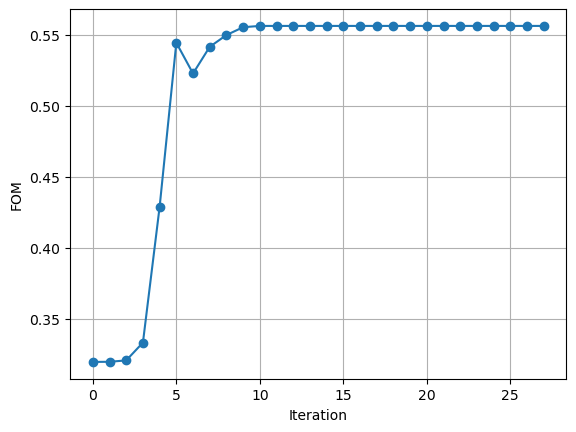

In [10]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

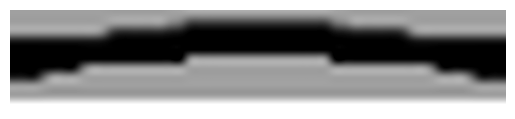

In [11]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

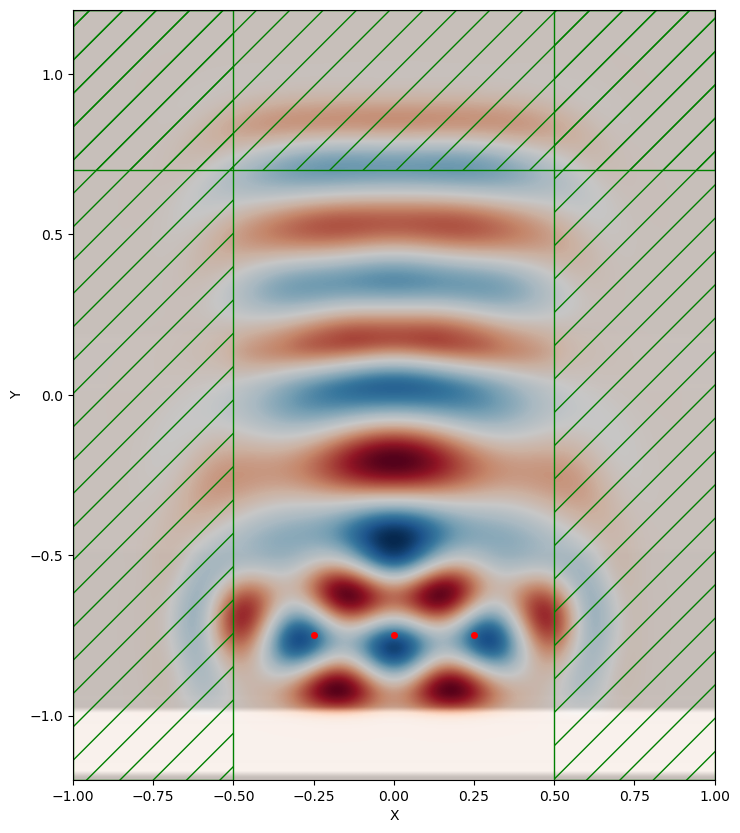

In [67]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

In [38]:
opt.sim.reset_meep()

In [39]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)

In [40]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = (design_region_width)*(math.trunc(src_num)/(src_num+1))
srcbox_top = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))



<Axes: xlabel='X', ylabel='Y'>

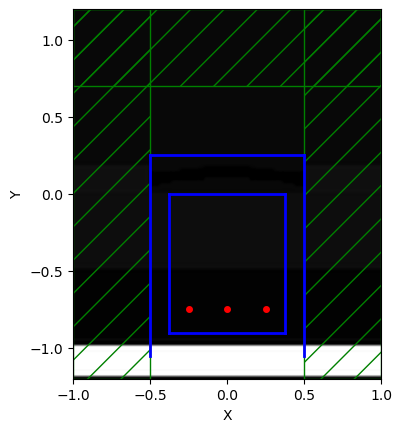

In [41]:
opt.sim.plot2D()

In [42]:
opt.sim.run(until=100.0)

In [43]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)



In [44]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

In [45]:
print(flux_waveguide)

[3.90423440e-06 2.29787996e-05 1.10963794e-04 3.87717806e-04
 1.14924217e-03 3.33818720e-03 8.47223848e-03 1.27800279e-02
 2.32071239e-02 6.57391287e-02 1.77910800e-01 3.73006543e-01
 5.72940095e-01 6.83388170e-01 7.08746890e-01 6.35490354e-01
 4.81981977e-01 3.09446371e-01 1.71883985e-01 8.20794761e-02
 3.33616355e-02 1.15801682e-02 3.48769033e-03 9.13255660e-04
 2.04963345e-04]


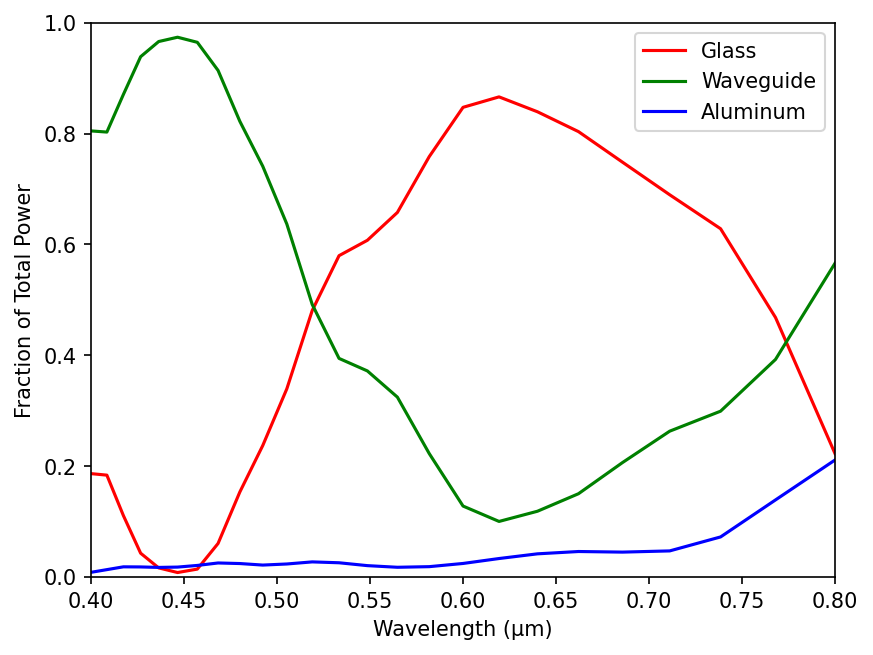

In [49]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [55]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

In [59]:
opt.simo.reset_meep()

In [60]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)

In [61]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = (design_region_width)*(math.trunc(src_num)/(src_num+1))
srcbox_top = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))


<Axes: xlabel='X', ylabel='Y'>

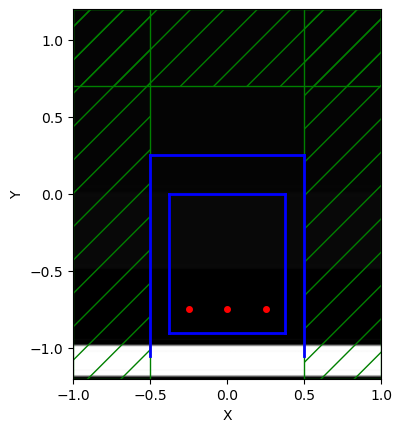

In [62]:
opt.simo.plot2D()

In [63]:
opt.simo.run(until=300.0)

In [64]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)


In [65]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

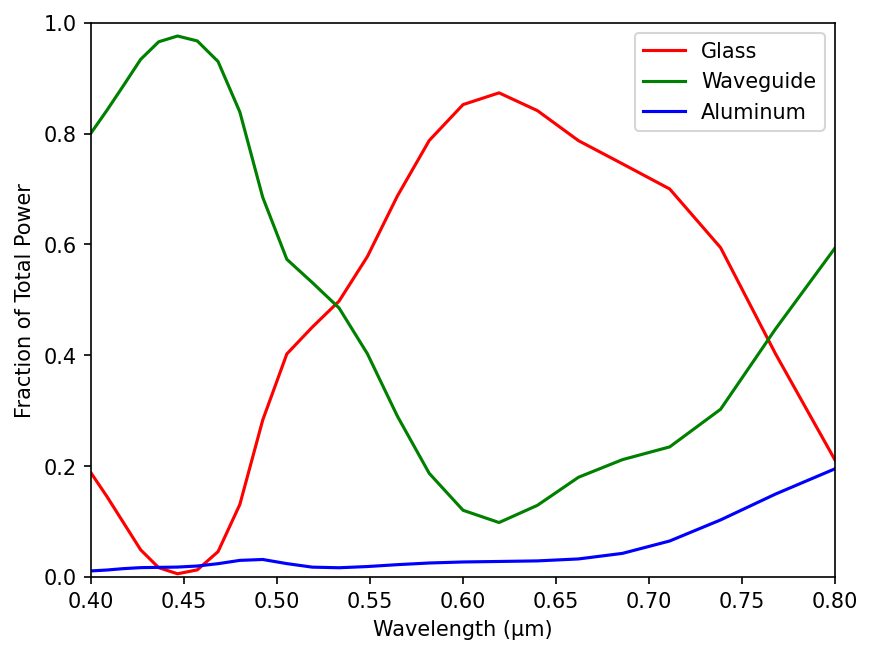

In [66]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

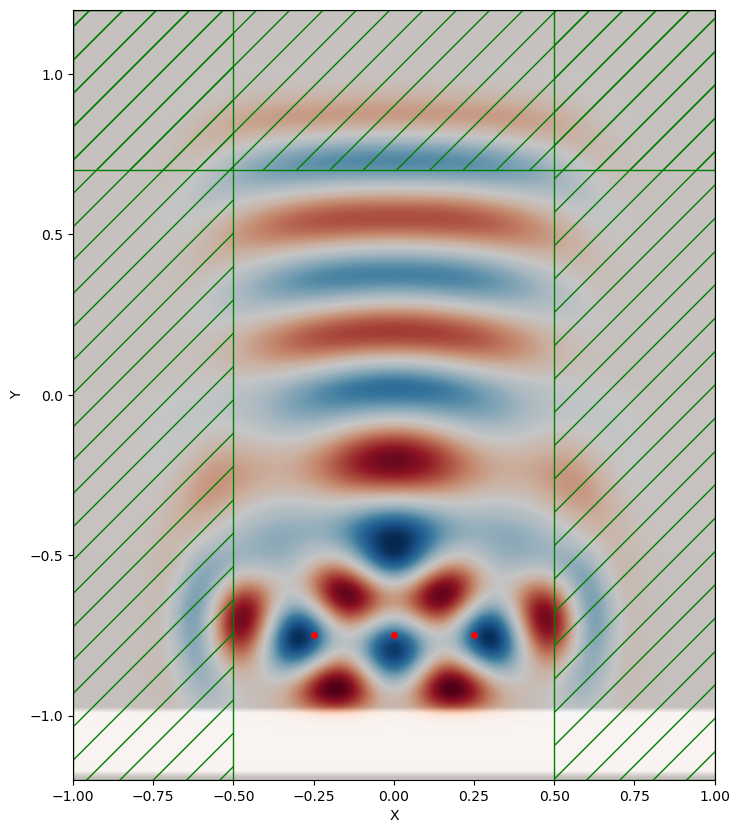

In [69]:
opt.simo.reset_meep()
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

opt.simo.change_sources(source)

plt.figure(figsize=(16, 10))

opt.simo.run(until=300)
opt.simo.plot2D(fields=mp.Ez)
opt.simo.reset_meep()